### Monte Carlo DLA

Reusing from 2.1.1 for compatibility and simplicity

In [92]:
# Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LogNorm
from IPython.display import Image, display

# Utility & Logging
import os
import time
import sys
import logbook
from logbook import Logger, StreamHandler, FileHandler, DEBUG, INFO, WARNING, ERROR, NOTSET
from tqdm.notebook import tqdm

# Core numerical processing
import numpy as np
from numba import jit, prange
import random

In [93]:
np.random.seed(42)
random.seed(42)

DATA_PATH = 'data/ex2'
MEDIA_PATH = 'temp_media/ex2'
LOG_PATH = 'log'
ANIM_BACKEND = 'ffmpeg'
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MEDIA_PATH, exist_ok=True)
os.makedirs(LOG_PATH, exist_ok=True)

log = Logger('MC-DLA')
fh = FileHandler(f'{LOG_PATH}/ex2_1_2.log', mode='w', level=WARNING, bubble=True)
h = StreamHandler(sys.stdout, level=WARNING, bubble=True)
fh.push_application()
h.push_application()

In [94]:
def get_seed_position(Nx, seed_pos: str):
    arg_list = seed_pos.lower().split(' ')

    if len(arg_list) == 0 or len(arg_list) == 1 and arg_list[0] != 'center':
        raise ValueError('Invalid seed position. Please provide positioning for both x and y coordinates or use "center".')
    elif len(arg_list) == 1 and arg_list[0] == 'center':
        return (Nx//2, Nx//2)

    seed_pos_h_dict = {
        'left': 0,
        'center': Nx//2,
        'right': Nx-1
    }

    x = seed_pos_h_dict.get(arg_list[-1], None)
        
    seed_pos_v_dict = {
        'lower': 0,
        'center': Nx//2,
        'upper': Nx-1
    }

    y = seed_pos_v_dict.get(arg_list[0], None)

    if x == None or y == None:
        raise ValueError('Invalid seed position. Please provide valid positioning for both x and y coordinates or use "center".')

    return (x, y)

New code from here

In [ ]:
fh.pop_application()
fh = FileHandler(f'{LOG_PATH}/ex2_1_2.log', mode='w', level=WARNING, bubble=True)

In [129]:
def init_grid(Nx=100, seed_pos='lower center'):
    obj_grid = np.zeros((Nx, Nx))
    seed_pos_idx = get_seed_position(Nx, seed_pos)
    log.info(f'Seed position: {seed_pos_idx}')
    obj_grid[*seed_pos_idx] = 1
    return obj_grid

def get_possible_steps(neighborhood):
    possible_steps = None
    if neighborhood == 'von_neumann':
        possible_steps = np.array([(1, 0), (0, 1), (-1, 0), (0, -1)])
    elif neighborhood == 'moore':
        possible_steps = np.array([(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (-1, 1), (1, -1), (-1, -1)])
    else:
        log.error('Unsupported neighborhood type. Using von Neumann instead.')
        possible_steps = np.array([(1, 0), (0, 1), (-1, 0), (0, -1)])
    return possible_steps

def spawn_walkers(n_walkers, Nx):
    x = np.random.choice(Nx, size=n_walkers, replace=True)
    log.debug(f'Spawning walkers at x = {x}')
    return [[x[i], Nx-1] for i in range(n_walkers)]


def walkers_step_iterative(walkers, possible_steps, obj_grid, Nx):
    remove_walkers = []
    
    for i, walker in enumerate(walkers):
        x, y = walker
        step_x, step_y = random.choice(possible_steps)
        candidate_pos = ((x + step_x) % Nx, y + step_y) # periodic boundary in x

        if candidate_pos[1] > Nx-1 or candidate_pos[1] < 0:  # Walks out of grid in y
            log.debug(f'Walker attempted to move out of grid to {candidate_pos}. Removing walker.')
            remove_walkers.append(walker)
            continue
        try:
            if obj_grid[candidate_pos] == 1: # Trying to move to occupied site
                log.debug(f'Walker attempted to step on occupied site at {candidate_pos}. Leaving it be.')
                continue
        except IndexError: # Somehow still trying to move out of the grid
            log.error(f'Walker attempted to move out of grid to {candidate_pos}. This attempt should not be possible.')
            remove_walkers.append(walker)
            continue

        walkers[i] = candidate_pos

    for walker in remove_walkers:
        walkers.remove(walker)

    return walkers

def walkers_step(walkers, possible_steps, obj_grid, Nx):
    walkers = np.array(walkers)

    step_indices = np.random.choice(len(possible_steps), size=len(walkers), replace=True)
    steps = possible_steps[step_indices]

    candidate_positions = walkers + steps
    candidate_positions[:, 0] %= Nx # periodic boundary in x

    walkers_in_grid = (candidate_positions[:, 1] < Nx) & (candidate_positions[:, 1] >= 0)
    walkers_on_occupied_tiles = np.zeros(len(walkers), dtype=bool)
    walkers_on_occupied_tiles[walkers_in_grid] = obj_grid[candidate_positions[walkers_in_grid, 0], candidate_positions[walkers_in_grid, 1]] != 1

    valid_moves = walkers_on_occupied_tiles
    walkers[valid_moves] = candidate_positions[valid_moves]

    return walkers[valid_moves].tolist()

def walkers_attempt_join_cluster_iterative(walkers, obj_grid, Nx, sticky_p=1.0):
    remove_walkers = []
    for i, walker in enumerate(walkers):
        x, y = walker
        if obj_grid[*walker] == 1:
            log.info(f'Walker is on occupied site at {x},{y}. Removing walker.')
            remove_walkers.append(walker)
            log.debug(f'Walker count: {len(walkers)}')
            continue
        if y == 0:
            neighbors = obj_grid[x - 1, y] + obj_grid[(x + 1) % Nx, y] + obj_grid[x, y + 1]
        elif y == Nx-1:
            neighbors = obj_grid[x - 1, y] + obj_grid[(x + 1) % Nx, y] + obj_grid[x, y - 1]
        else:
            neighbors = obj_grid[x - 1, y] + obj_grid[(x + 1) % Nx, y] + obj_grid[x, y + 1] + obj_grid[x, y - 1]

        if neighbors > 0:
            log.debug(f'Walker at {walker} has {neighbors} neighbors. Attempting to join object.')
            p = np.random.uniform()
            if p < sticky_p:
                obj_grid[*walker] = 1
                log.info(f'Walker joining object at {walker}. Object size: {np.sum(obj_grid)}')
                remove_walkers.append(walker)
                log.debug(f'Walker count: {len(walkers)}')

    for walker in remove_walkers:
        walkers.remove(walker)

    return walkers, obj_grid

def walkers_attempt_join_cluster(walkers, obj_grid, possible_steps, Nx, sticky_p=1.0):
    N_walkers = len(walkers)

    if N_walkers == 0:
        return walkers, obj_grid
    
    walkers = np.array(walkers)
    
    # Remove walkers on occupied sites
    valid_walkers = obj_grid[walkers[:, 0], walkers[:, 1]] != 1
    walkers = walkers[valid_walkers]

    # Get neighbors of the walkers
    x, y = walkers.T

    neighbor_sum = np.zeros(len(walkers))
    for s_x, s_y in possible_steps:
        x_neighbors = (x + s_x) % Nx
        y_neighbors = np.clip(y + s_y, 0, Nx - 1)
        neighbor_sum += obj_grid[x_neighbors, y_neighbors]

    # Attempt to join the object # TODO: check why this doesn't work with sticky p < 1???
    p = np.random.uniform(size=len(walkers))
    successfully_join = p < sticky_p
    walkers_to_join = walkers[neighbor_sum > 0 & successfully_join]
    obj_grid[walkers_to_join[:, 0], walkers_to_join[:, 1]] = 1

    # Remove walkers that joined the object
    walkers = walkers[~(neighbor_sum > 0 & successfully_join)]

    return walkers.tolist(), obj_grid

In [137]:
def simulate_with_random_walkers(Nx=100, T=1_000, spawn_rate=1, max_walkers=50, sticky_p=1.0, neighborhood='von_neumann', seed_pos='lower center', return_history=False):
    '''Spawns random walkers at a constant rate (spawn_rate per time iteration) and simulates their random walk through the grid for T iterations.
    Random walkers are removed if they leave the grid or if they attach to the growth object (with probability sticky_p).'''
    obj_grid = init_grid(Nx=Nx, seed_pos=seed_pos)
    walkers = []
    possible_steps = get_possible_steps(neighborhood=neighborhood)

    obj_grid_history = []
    walkers_history = []

    for t in tqdm(range(T), desc='Simulating walkers through time', leave=False, position=0, file=sys.stdout):
        log.debug(f'Simulating random walk at t={t}')
        if len(walkers) < max_walkers:
            spawn_n_walkers = min(spawn_rate, max_walkers - len(walkers))
            new_walkers = spawn_walkers(n_walkers=spawn_n_walkers, Nx=Nx)
            log.debug(f'{spawn_n_walkers} walkers spawned at t={t} at positions {new_walkers}')
            walkers += new_walkers
            log.debug(f'New walker count: {len(walkers)}')
        
        walkers = walkers_step(walkers, possible_steps, obj_grid, Nx)
        log.debug(f'Walker count: {len(walkers)}')
        
        walkers, obj_grid = walkers_attempt_join_cluster(walkers, obj_grid, possible_steps, Nx, sticky_p)
        log.debug(f'Walker count: {len(walkers)}')

        if return_history:
            obj_grid_history.append(obj_grid.copy())
            walkers_history.append(walkers.copy())

        if np.any(obj_grid[:, Nx-1]) == 1:
            log.warning(f'Object reached top of grid at t={t}. Terminating simulation.')
            break

    if return_history:
        return obj_grid, walkers, t, obj_grid_history, walkers_history
    else:
        return obj_grid, walkers, t

In [156]:
def plot_object_with_walkers(obj, walkers, title, filename, save=True):
    plt.figure(figsize=(5, 4), layout='tight')
    cmap = plt.get_cmap('grey')

    walkers_grid = np.zeros_like(obj)

    for x, y in walkers:
        walkers_grid[x, y] = 1

    rgba_img = cmap(np.rot90(obj, 3))
    rgba_img[np.rot90(obj, 3) == 1, :3] = 1

    rgba_img[np.rot90(walkers_grid, 3) == 1, :3] = [0.5, 0.5, 0.5]

    plt.imshow(rgba_img, origin='lower')

    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    if save:
        plt.savefig(f'{MEDIA_PATH}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

def animate_object_with_walkers(obj_grid_history, walkers_history, title, filename, save=True, frame_step=1):
    cmap = plt.get_cmap('gray')
    norm = Normalize(vmin=0, vmax=1)
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.set_title('DLA growth animation')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    obj_grid_frames = obj_grid_history[::frame_step]
    walkers_frames = walkers_history[::frame_step]
    t_values = np.concatenate((np.arange(0, len(obj_grid_history), frame_step), [len(obj_grid_history)-1]))
    obj_grid_frames.append(obj_grid_history[-1])
    walkers_frames.append(walkers_history[-1])

    def anim_frame(i):
        ax.clear()
        ax.imshow(cmap(np.rot90(obj_grid_frames[i], 3)), origin='lower', norm=norm)
        walkers_grid = np.zeros_like(obj_grid_frames[i])
        for x, y in walkers_frames[i]:
            walkers_grid[x, y] = 1
        ax.imshow(cmap(np.rot90(walkers_grid, 3)), origin='lower', norm=norm, alpha=0.5)
        ax.set_title(f'{title} at $t={t_values[i]}$')
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    ani = anim.FuncAnimation(fig, anim_frame, frames=len(obj_grid_frames), interval=17, repeat=False)
    if save:
        ani.save(f'{MEDIA_PATH}/{filename}.mp4', fps=60, writer=ANIM_BACKEND, bitrate=1800)
    plt.show()

Simulating walkers through time:   0%|          | 0/100000 [00:00<?, ?it/s]

[2024-03-12 21:51:59.565613] WARNING: MC-DLA: Object reached top of grid at t=62702. Terminating simulation.
[2024-03-12 21:51:59.565613] WARNING: MC-DLA: Object reached top of grid at t=62702. Terminating simulation.


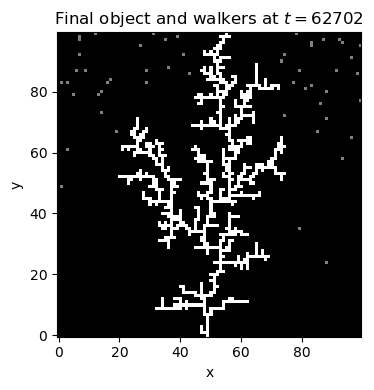

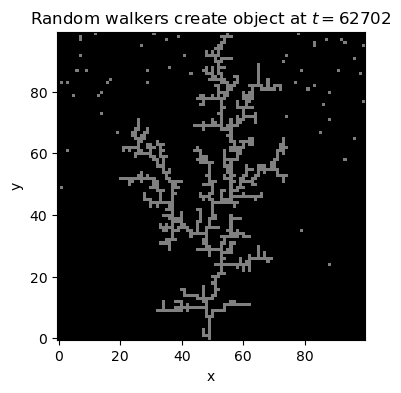

In [159]:
final_obj, final_walkers, iters, obj_grid_history, walkers_history = simulate_with_random_walkers(Nx=100, T=100_000, spawn_rate=1, max_walkers=1000, sticky_p=0.01, neighborhood='von_neumann', seed_pos='lower center', return_history=True)
plot_object_with_walkers(final_obj, final_walkers, f'Final object and walkers at $t={iters}$', f'final_object_and_walkers_at_t={iters}', save=True)
animate_object_with_walkers(obj_grid_history, walkers_history, 'Random walkers create object', f'random_walkers_create_object', save=True, frame_step=250)

Growth object grid after a single random walker connects

In [124]:
# Testing sticky p
sticky_1 = simulate_walks(init_grid(), num_steps, sticky_p=0.5)
sticky_2 = simulate_walks(init_grid(), num_steps, sticky_p=0.2)
sticky_3 = simulate_walks(init_grid(), num_steps, sticky_p=0.1)

NameError: name 'simulate_walks' is not defined

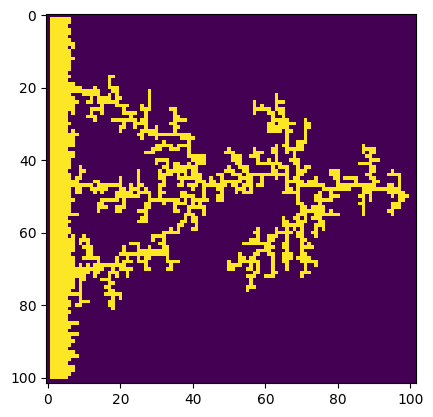

In [ ]:
plt.imshow(sticky_1)

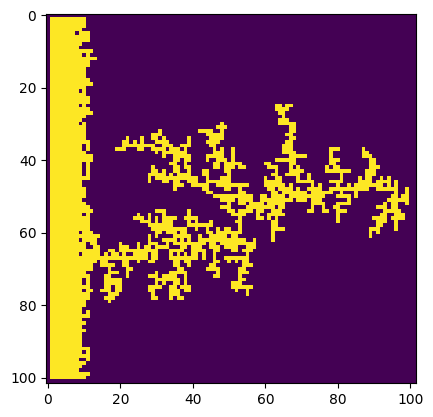

In [ ]:
plt.imshow(sticky_2)

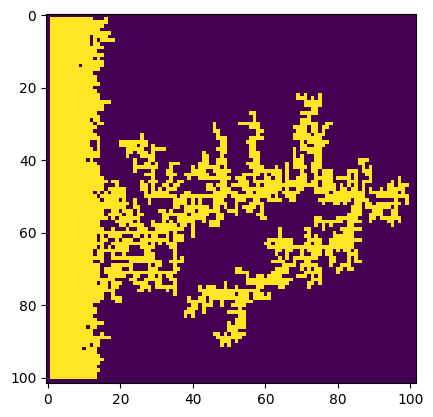

In [ ]:
plt.imshow(sticky_3)